<a href="https://colab.research.google.com/github/ssnithyaasri/SUPER-STACK-Ensemble-for-Multiclass-Rheumatic-Disease-Diagnosis/blob/main/PROJECTCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Before resampling: (10181, 18) Class counts: [2047 1067 1726  495 2744 1225  877]
✅ After SMOTEENN: (13408, 18) Class counts: [ 802 2253 1986 2628 1026 2045 2668]

🔄 Training Logistic Regression...
   ✅ Accuracy:  0.8908
   ✅ Precision: 0.8882
   ✅ Recall:    0.8908
   ✅ F1-score:  0.8888

🔄 Training SVM (RBF)...
   ✅ Accuracy:  0.9433
   ✅ Precision: 0.9426
   ✅ Recall:    0.9433
   ✅ F1-score:  0.9422

🔄 Training KNN...
   ✅ Accuracy:  0.8937
   ✅ Precision: 0.8939
   ✅ Recall:    0.8937
   ✅ F1-score:  0.8865

🔄 Training Gaussian NB...
   ✅ Accuracy:  0.8900
   ✅ Precision: 0.8939
   ✅ Recall:    0.8900
   ✅ F1-score:  0.8906

🔄 Training MLP Neural Net...
   ✅ Accuracy:  0.9366
   ✅ Precision: 0.9370
   ✅ Recall:    0.9366
   ✅ F1-score:  0.9367

🔄 Training Random Forest...
   ✅ Accuracy:  0.9646
   ✅ Precision: 0.9644
   ✅ Recall:    0.9646
   ✅ F1-score:  0.9643

🔄 Training XGBoost...
   ✅ Accuracy:  0.9743
   ✅ Precision: 0.9741
   ✅ Recall:    0.9743
   ✅ F1-score:  0.9740

🔄 

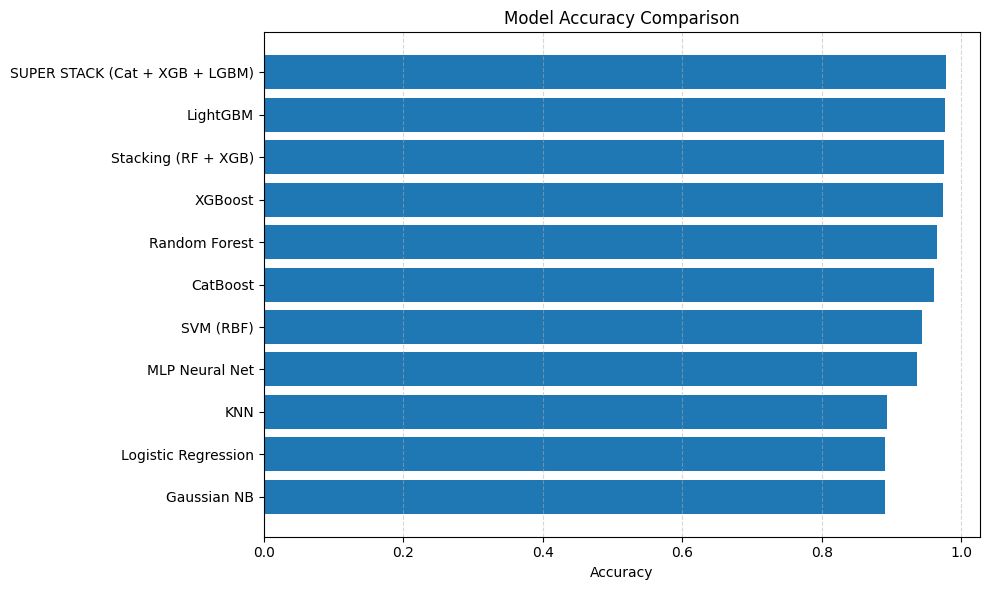


🏆 Best Model Selected for Confusion Matrix: SUPER STACK (Cat + XGB + LGBM)


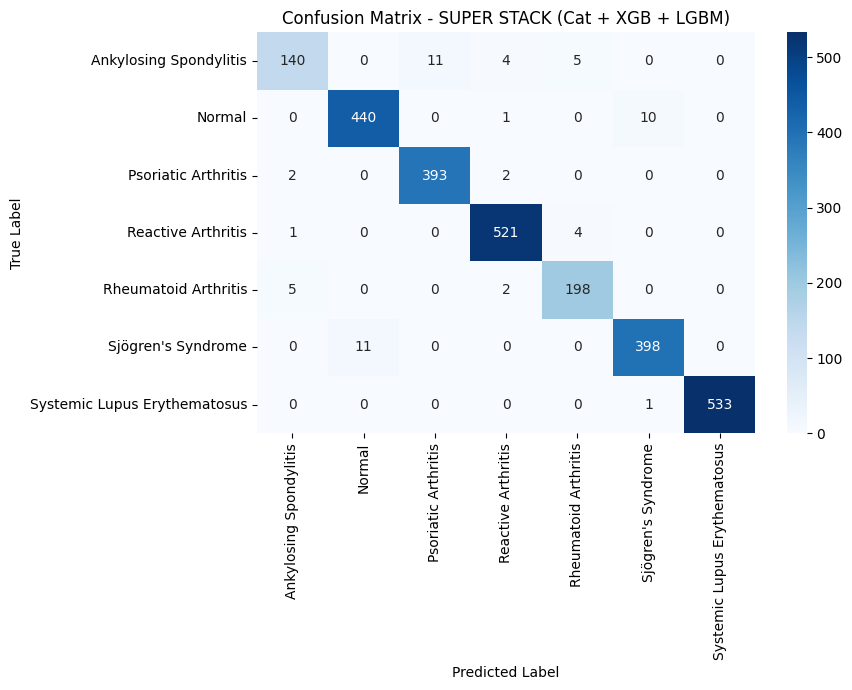


🔍 Using CatBoost as the final model for XAI


In [ ]:


!pip install -q catboost lightgbm xgboost imbalanced-learn shap seaborn openpyxl

# ---------------- Imports ----------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# ======================================================
# 1. LOAD DATASET
# ======================================================
DATA_PATH = "/content/Rheumatic-and-Autoimmune-Disease-Dataset.xlsx"
df = pd.read_excel(DATA_PATH)

# Remove unnamed index-like columns if present
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace common missing markers with NaN
df = df.replace(["?", "Unknown", "NA", "N/A", None], np.nan)

# Define columns
categorical = ["Gender", "HLA-B27", "ANA", "Anti-Ro", "Anti-La", "Anti-dsDNA", "Anti-Sm"]
numeric = ["Age", "ESR", "CRP", "RF", "Anti-CCP", "C3", "C4"]
target = "Disease"

# ======================================================
# 2. HANDLE MISSING VALUES
# ======================================================
# Categorical → "Missing"
for col in categorical:
    df[col] = df[col].fillna("Missing")

# Numeric → convert to numeric, then median
df[numeric] = df[numeric].apply(pd.to_numeric, errors="coerce")
df[numeric] = df[numeric].fillna(df[numeric].median())

# Drop rows with missing target
df = df.dropna(subset=[target]).reset_index(drop=True)

# ======================================================
# 3. FEATURE ENGINEERING
# ======================================================
# Inflammation score
df["Inflammation_Score"] = df["ESR"] + df["CRP"]

# ESR/CRP ratio (avoid division by zero)
df["ESR_CR_Ratio"] = df["ESR"] / (df["CRP"] + 1)

# Autoantibody count (how many markers are present, not "Missing")
auto_cols = ["ANA", "Anti-Ro", "Anti-La", "Anti-dsDNA", "Anti-Sm"]
df["AutoAb_Count"] = df[auto_cols].apply(
    lambda row: sum(val != "Missing" for val in row),
    axis=1
)

# Age group (binning)
df["Age_Group"] = pd.cut(
    df["Age"],
    bins=[0, 18, 35, 50, 120],
    labels=[0, 1, 2, 3],
    include_lowest=True
).astype(int)

numeric_extended = numeric + ["Inflammation_Score", "ESR_CR_Ratio", "AutoAb_Count", "Age_Group"]

# ======================================================
# 4. OUTLIER REMOVAL USING IQR ON NUMERIC FEATURES
# ======================================================
def remove_outliers(df, cols, factor=1.5):
    clean_df = df.copy()
    for c in cols:
        q1 = clean_df[c].quantile(0.25)
        q3 = clean_df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        clean_df = clean_df[(clean_df[c] >= lower) & (clean_df[c] <= upper)]
    return clean_df.reset_index(drop=True)

df = remove_outliers(df, numeric_extended)

# ======================================================
# 5. ENCODING CATEGORICAL + TARGET
# ======================================================
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

le_y = LabelEncoder()
df[target] = le_y.fit_transform(df[target])

# ======================================================
# 6. DEFINE FEATURES & TARGET
# ======================================================
feature_cols = categorical + numeric_extended
X = df[feature_cols].copy()
y = df[target].copy()

# ======================================================
# 7. HANDLE CLASS IMBALANCE (SMOTEENN)
# ======================================================
print("✅ Before resampling:", X.shape, "Class counts:", np.bincount(y))

smote_enn = SMOTEENN(random_state=42)
X_bal, y_bal = smote_enn.fit_resample(X, y)

print("✅ After SMOTEENN:", X_bal.shape, "Class counts:", np.bincount(y_bal))

# ======================================================
# 8. TRAIN/TEST SPLIT + SCALING
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

scaler = RobustScaler()
X_train[numeric_extended] = scaler.fit_transform(X_train[numeric_extended])
X_test[numeric_extended] = scaler.transform(X_test[numeric_extended])

# ======================================================
# 9. DEFINE MODELS (TUNED)
# ======================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "SVM (RBF)": SVC(C=3.0, kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "Gaussian NB": GaussianNB(),
    "MLP Neural Net": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=800,
        alpha=0.0005,
        learning_rate_init=0.001,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=600,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=600,
        depth=8,
        learning_rate=0.03,
        l2_leaf_reg=5,
        loss_function="MultiClass",
        verbose=0,
        random_state=42
    ),
    "Stacking (RF + XGB)": StackingClassifier(
        estimators=[
            ("rf", RandomForestClassifier(
                n_estimators=500,
                max_depth=14,
                random_state=42
            )),
            ("xgb", XGBClassifier(
                n_estimators=350,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="mlogloss",
                random_state=42
            ))
        ],
        final_estimator=LogisticRegression(max_iter=2000),
        n_jobs=-1
    ),
    "SUPER STACK (Cat + XGB + LGBM)": StackingClassifier(
        estimators=[
            ("cat", CatBoostClassifier(
                iterations=400,
                depth=8,
                learning_rate=0.05,
                verbose=0,
                random_state=42
            )),
            ("xgb", XGBClassifier(
                n_estimators=400,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="mlogloss",
                random_state=42
            )),
            ("lgb", LGBMClassifier(
                n_estimators=400,
                learning_rate=0.05,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            ))
        ],
        final_estimator=CatBoostClassifier(
            iterations=300,
            learning_rate=0.03,
            depth=6,
            verbose=0,
            random_state=42
        ),
        n_jobs=-1
    )
}

# ======================================================
# 10. TRAIN + EVALUATE ALL MODELS
# ======================================================
results = []
trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

    print(f"   ✅ Accuracy:  {acc:.4f}")
    print(f"   ✅ Precision: {prec:.4f}")
    print(f"   ✅ Recall:    {rec:.4f}")
    print(f"   ✅ F1-score:  {f1:.4f}")

    results.append([name, acc, prec, rec, f1])
    trained_models[name] = model

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n📊 MODEL COMPARISON TABLE:")
print(results_df)

# ======================================================
# 11. BAR CHART OF ACCURACY
# ======================================================
plt.figure(figsize=(10, 6))
plt.barh(results_df["Model"], results_df["Accuracy"])
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.gca().invert_yaxis()  # best at top
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ======================================================
# 12. CONFUSION MATRIX (BEST MODEL)
# ======================================================
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print(f"\n🏆 Best Model Selected for Confusion Matrix: {best_model_name}")

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=le_y.classes_,
    yticklabels=le_y.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

# ======================================================
# 13. EXPLAINABLE AI (SHAP) + PATIENT PREDICTION
# ======================================================

# Choose a model for XAI (CatBoost is best for SHAP)
xai_model_name = "CatBoost"
if xai_model_name not in trained_models:
    xai_model_name = best_model_name  # fallback
final_model_name = xai_model_name
final_model = trained_models[final_model_name]

print(f"\n🔍 Using {final_model_name} as the final model for XAI")

explainer = shap.TreeExplainer(final_model)

def build_patient_df(
    age, esr, crp, rf, anti_ccp, c3, c4,
    gender, hla_b27, ana, anti_ro, anti_la, anti_dsdna, anti_sm
):
    """
    Build a single-row dataframe for a new patient,
    applying SAME preprocessing + feature engineering.
    """
    raw = {
        "Age": age,
        "ESR": esr,
        "CRP": crp,
        "RF": rf,
        "Anti-CCP": anti_ccp,
        "C3": c3,
        "C4": c4,
        "Gender": gender,
        "HLA-B27": hla_b27,
        "ANA": ana,
        "Anti-Ro": anti_ro,
        "Anti-La": anti_la,
        "Anti-dsDNA": anti_dsdna,
        "Anti-Sm": anti_sm,
    }
    df_p = pd.DataFrame([raw])

    # Feature engineering (same as training)
    df_p["Inflammation_Score"] = df_p["ESR"] + df_p["CRP"]
    df_p["ESR_CR_Ratio"] = df_p["ESR"] / (df_p["CRP"] + 1)

    auto_cols = ["ANA", "Anti-Ro", "Anti-La", "Anti-dsDNA", "Anti-Sm"]
    df_p["AutoAb_Count"] = df_p[auto_cols].apply(
        lambda row: sum(val != "Missing" for val in row),
        axis=1
    )

    df_p["Age_Group"] = pd.cut(
        df_p["Age"],
        bins=[0, 18, 35, 50, 120],
        labels=[0, 1, 2, 3],
        include_lowest=True
    ).astype(int)

    # Encode categoricals using stored label_encoders
    df_p_encoded = df_p.copy()
    for col in categorical:
        le = label_encoders[col]
        if df_p_encoded[col].iloc[0] not in le.classes_:
            if "Missing" in le.classes_:
                df_p_encoded[col] = "Missing"
            else:
                df_p_encoded[col] = le.classes_[0]
        df_p_encoded[col] = le.transform(df_p_encoded[col])

    # Keep same feature order
    df_p_encoded = df_p_encoded[feature_cols].copy()

    # Scale numeric features
    df_p_encoded[numeric_extended] = scaler.transform(df_p_encoded[numeric_extended])

    return df_p, df_p_encoded

def explain_patient(
    age, esr, crp, rf, anti_ccp, c3, c4,
    gender, hla_b27, ana, anti_ro, anti_la, anti_dsdna, anti_sm
):
    df_p_raw, df_p_model = build_patient_df(
        age, esr, crp, rf, anti_ccp, c3, c4,
        gender, hla_b27, ana, anti_ro, anti_la, anti_dsdna, anti_sm
    )

    # Predict probabilities
    probs = final_model.predict_proba(df_p_model)[0]
    class_indices = np.argsort(probs)[::-1]
    class_names = le_y.inverse_transform(class_indices)

    top1_idx = class_indices[0]
    top1_label = class_names[0]
    top1_prob = probs[top1_idx]

    top3_labels = class_names[:3]
    top3_probs = probs[class_indices[:3]]

    print("\n🔮 Prediction Results:")
    print(f"Most likely disease: {top1_label} ({top1_prob*100:.2f}%)")
    print("Top 3 predictions:")
    for lbl, p in zip(top3_labels, top3_probs):
        print(f"  • {lbl} — {p*100:.2f}%")

    # SHAP values (multiclass → list)
    shap_values = explainer.shap_values(df_p_model)
    shap_for_pred_class = shap_values[top1_idx][0]

    feature_importance = pd.DataFrame({
        "feature": df_p_model.columns,
        "shap_value": shap_for_pred_class,
        "abs_shap": np.abs(shap_for_pred_class)
    }).sort_values(by="abs_shap", ascending=False)

    print("\n📌 Top factors influencing this prediction:")
    for i in range(5):
        row = feature_importance.iloc[i]
        print(f"  {i+1}. {row['feature']} (SHAP: {row['shap_value']:.4f})")

    # Local SHAP bar plot
    shap.summary_plot(shap_values[top1_idx], df_p_model, plot_type="bar", show=True)

    # Waterfall plot
    expl = shap.Explanation(
        values=shap_for_pred_class,
        base_values=explainer.expected_value[top1_idx],
        data=df_p_model.iloc[0],
        feature_names=df_p_model.columns
    )
    shap.waterfall_plot(expl, max_display=12)

    return top1_label, top1_prob, list(zip(top3_labels, top3_probs)), df_p_raw, df_p_model, top1_idx

# ======================================================
# 14. GLOBAL SHAP SUMMARY PLOTS
# ======================================================
shap_values_full = explainer.shap_values(X_train)

print("\n🌐 Global SHAP summary plot:")
shap.summary_plot(shap_values_full, X_train)

print("\n📊 Global SHAP bar plot:")
shap.summary_plot(shap_values_full, X_train, plot_type="bar")

# ======================================================
# 15. RUN EXPLANATION FOR YOUR SAMPLE PATIENT
# ======================================================
top1_label, top1_prob, top3, patient_raw, patient_model, top1_idx = explain_patient(
    age=45,
    esr=28,
    crp=10,
    rf=35,
    anti_ccp=20,
    c3=130,
    c4=40,
    gender="Female",
    hla_b27="Positive",
    ana="Negative",
    anti_ro="Negative",
    anti_la="Negative",
    anti_dsdna="Positive",
    anti_sm="Negative"
)


✅ Before resampling: (10181, 18) Class counts: [2047 1067 1726  495 2744 1225  877]
✅ After SMOTEENN: (13408, 18) Class counts: [ 802 2253 1986 2628 1026 2045 2668]

🔄 Training base model: Random Forest ...
   ✅ Random Forest  Acc:0.9661  Prec:0.9659  Rec:0.9661  F1:0.9656

🔄 Training base model: XGBoost ...
   ✅ XGBoost  Acc:0.9720  Prec:0.9719  Rec:0.9720  F1:0.9717

🔄 Training base model: LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 10726, number of used features: 18
[LightGBM] [Info] Start training from score -2.815838
[LightGBM] [Info] Start training from score -1.783774
[LightGBM] [Info] Start training from score -1.909566
[LightGBM] [Info] Start training from score -1.629781
[LightGBM] [Info] Start

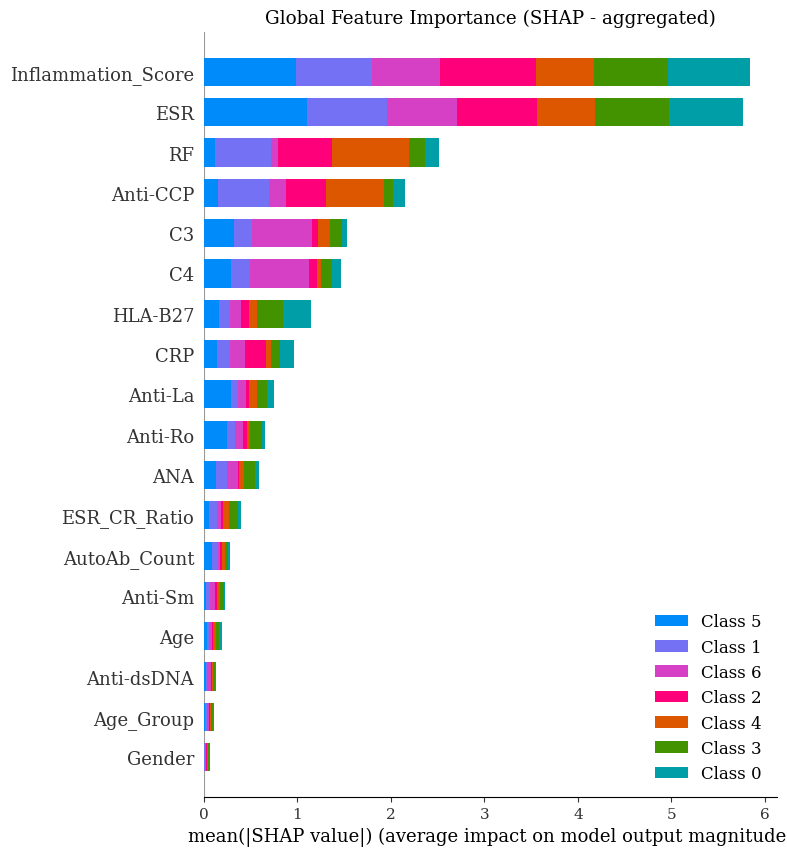

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7294cbbeeb658b5a22.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
# ======================================================
# 📊 RHEUMATIC DISEASE PREDICTION - FULL PIPELINE + STACKING + SHAP + GRADIO APP
# ======================================================

# Install required packages
!pip install -q catboost lightgbm xgboost imbalanced-learn openpyxl seaborn shap gradio pillow joblib

# ---------------- Imports ----------------
import os, io, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gradio as gr
import joblib
from PIL import Image

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTEENN

%matplotlib inline

# ======================================================
# 0. File path (update if needed)
# ======================================================
DATA_PATH = "/content/Rheumatic-and-Autoimmune-Disease-Dataset.xlsx"  # change if file located elsewhere

# ======================================================
# 1. LOAD DATASET
# ======================================================
df = pd.read_excel(DATA_PATH, engine="openpyxl")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.replace(["?", "Unknown", "NA", "N/A", None], np.nan)

# ======================================================
# 2. COLUMNS & MISSING HANDLING
# ======================================================
categorical = ["Gender", "HLA-B27", "ANA", "Anti-Ro", "Anti-La", "Anti-dsDNA", "Anti-Sm"]
numeric = ["Age", "ESR", "CRP", "RF", "Anti-CCP", "C3", "C4"]
target = "Disease"

# fill categoricals with explicit 'Missing'
for col in categorical:
    df[col] = df[col].fillna("Missing").astype(str)

# numeric -> coerce then median fill
df[numeric] = df[numeric].apply(pd.to_numeric, errors="coerce")
df[numeric] = df[numeric].fillna(df[numeric].median())

# drop rows missing target
df = df.dropna(subset=[target]).reset_index(drop=True)

# ======================================================
# 3. FEATURE ENGINEERING
# ======================================================
df["Inflammation_Score"] = df["ESR"] + df["CRP"]
df["ESR_CR_Ratio"] = df["ESR"] / (df["CRP"] + 1)
auto_cols = ["ANA", "Anti-Ro", "Anti-La", "Anti-dsDNA", "Anti-Sm"]
df["AutoAb_Count"] = df[auto_cols].apply(lambda row: sum(val != "Missing" for val in row), axis=1)
df["Age_Group"] = pd.cut(df["Age"], bins=[0,18,35,50,120], labels=[0,1,2,3], include_lowest=True).astype(int)

numeric_extended = numeric + ["Inflammation_Score", "ESR_CR_Ratio", "AutoAb_Count", "Age_Group"]

# ======================================================
# 4. OUTLIER REMOVAL (IQR)
# ======================================================
def remove_outliers(df_in, cols, factor=1.5):
    clean_df = df_in.copy()
    for c in cols:
        q1 = clean_df[c].quantile(0.25)
        q3 = clean_df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        clean_df = clean_df[(clean_df[c] >= lower) & (clean_df[c] <= upper)]
    return clean_df.reset_index(drop=True)

df = remove_outliers(df, numeric_extended)

# ======================================================
# 5. ENCODE CATEGORICAL & TARGET
# ======================================================
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

le_y = LabelEncoder()
df[target] = le_y.fit_transform(df[target])

# ======================================================
# 6. PREPARE X, y
# ======================================================
feature_cols = categorical + numeric_extended
X = df[feature_cols].copy()
y = df[target].copy()

# ======================================================
# 7. HANDLE IMBALANCE (SMOTEENN)
# ======================================================
print("✅ Before resampling:", X.shape, "Class counts:", np.bincount(y))
smote_enn = SMOTEENN(random_state=42)
X_bal, y_bal = smote_enn.fit_resample(X, y)
print("✅ After SMOTEENN:", X_bal.shape, "Class counts:", np.bincount(y_bal))

# ======================================================
# 8. SPLIT & SCALE
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
scaler = RobustScaler()
X_train[numeric_extended] = scaler.fit_transform(X_train[numeric_extended])
X_test[numeric_extended] = scaler.transform(X_test[numeric_extended])

# ======================================================
# 9. BASE MODELS (for comparison)
# ======================================================
base_models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=15, class_weight="balanced_subsample", random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=400, depth=6, learning_rate=0.03, verbose=0, random_state=42)
}

results = []
trained_models = {}
for name, mdl in base_models.items():
    print(f"\n🔄 Training base model: {name} ...")
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1 = f1_score(y_test, preds, average="weighted", zero_division=0)
    print(f"   ✅ {name}  Acc:{acc:.4f}  Prec:{prec:.4f}  Rec:{rec:.4f}  F1:{f1:.4f}")
    results.append([name, acc, prec, rec, f1])
    trained_models[name] = mdl

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print("\n📊 BASE MODEL COMPARISON")
print(results_df)

# ======================================================
# 10. STACKING ENSEMBLES (RF+XGB and SUPER STACK)
# ======================================================
print("\n🔧 Building stacking ensembles...")

# Base learners for stacks (re-create with identical hyperparams)
rf_base = RandomForestClassifier(n_estimators=500, max_depth=14, random_state=42, n_jobs=-1)
xgb_base = XGBClassifier(n_estimators=350, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                         objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False, random_state=42, n_jobs=-1)

stack_rf_xgb = StackingClassifier(
    estimators=[("rf", rf_base), ("xgb", xgb_base)],
    final_estimator=LogisticRegression(max_iter=2000),
    n_jobs=-1,
    passthrough=False,
    verbose=1
)

cat_base = CatBoostClassifier(iterations=400, depth=8, learning_rate=0.05, verbose=0, random_state=42)
lgb_base = LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=31, random_state=42)

super_stack = StackingClassifier(
    estimators=[("cat", cat_base), ("xgb", xgb_base), ("lgb", lgb_base)],
    final_estimator=CatBoostClassifier(iterations=300, learning_rate=0.03, depth=6, verbose=0, random_state=42),
    n_jobs=-1,
    passthrough=False,
    verbose=1
)

stack_models = {"Stacking (RF + XGB)": stack_rf_xgb, "SUPER STACK (Cat + XGB + LGBM)": super_stack}
stack_results = {}
trained_stack_models = {}

for name, mdl in stack_models.items():
    print(f"\n🔄 Training stacking model: {name} ...")
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1 = f1_score(y_test, preds, average="weighted", zero_division=0)
    print(f"   ✅ {name}  Acc:{acc:.4f}  Prec:{prec:.4f}  Rec:{rec:.4f}  F1:{f1:.4f}")
    stack_results[name] = (acc, prec, rec, f1)
    trained_stack_models[name] = mdl
    # save stack model
    os.makedirs("./artifacts", exist_ok=True)
    joblib.dump(mdl, f"./artifacts/{name.replace(' ', '_')}.pkl")

stack_df = pd.DataFrame([[k]+list(v) for k,v in stack_results.items()], columns=["Model","Accuracy","Precision","Recall","F1 Score"]).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print("\n📊 STACKING MODEL COMPARISON")
print(stack_df)

# best overall model between base best and best stacking by accuracy
all_models = {**trained_models, **trained_stack_models}
# get accuracies for all
acc_map = {}
for name, mdl in all_models.items():
    try:
        preds = mdl.predict(X_test)
        acc_map[name] = accuracy_score(y_test, preds)
    except Exception:
        acc_map[name] = 0.0
acc_sorted = sorted(acc_map.items(), key=lambda x: x[1], reverse=True)
best_model_name = acc_sorted[0][0]
best_model = all_models[best_model_name]
print(f"\n🏆 Selected best model: {best_model_name} (accuracy={acc_sorted[0][1]:.4f})")

# Save best_model and supporting artifacts
ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
joblib.dump(best_model, os.path.join(ARTIFACT_DIR, "best_model.pkl"))
joblib.dump(scaler, os.path.join(ARTIFACT_DIR, "scaler.pkl"))
joblib.dump(label_encoders, os.path.join(ARTIFACT_DIR, "label_encoders.pkl"))
joblib.dump(le_y, os.path.join(ARTIFACT_DIR, "label_y.pkl"))
print(f"✅ Saved artifacts to {ARTIFACT_DIR}")

# ======================================================
# 11. SHAP EXPLAINABILITY
# ======================================================

if "CatBoost" in trained_models:
    shap_model = trained_models["CatBoost"]
elif "CatBoost" in trained_stack_models:
    shap_model = best_model
else:
    shap_model = best_model

# Take a sample for global SHAP
X_sample = X_train.sample(min(300, len(X_train)), random_state=42)
try:
    explainer = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_sample)
    # display global importance
    plt.title("Global Feature Importance (SHAP - aggregated)")
    if isinstance(shap_values, list):
        abs_sum = np.sum([np.abs(sv) for sv in shap_values], axis=0)
        shap.summary_plot(abs_sum, X_sample, plot_type="bar", show=True)
    else:
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)
except Exception as e:
    print("⚠️ SHAP TreeExplainer failed for chosen SHAP model:", e)
    explainer = None
    shap_values = None

# helper to convert figs to PIL for Gradio
def fig_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    buf.close()
    plt.close(fig)
    return img

def shap_local_image(explainer_obj, model_obj, X_instance_df):
    """Return PIL image for local SHAP (waterfall preferred)."""
    try:
        shap_vals = explainer_obj.shap_values(X_instance_df)
        base_value = getattr(explainer_obj, "expected_value", None)
        if isinstance(shap_vals, list):
            pred_cls = int(model_obj.predict(X_instance_df)[0])
            sv = np.array(shap_vals[pred_cls])
            bv = base_value[pred_cls] if isinstance(base_value, (list, np.ndarray)) else base_value
        else:
            sv = np.array(shap_vals)
            bv = base_value

        sv_inst = sv[0] if sv.ndim == 2 else sv
        feat_row = pd.DataFrame(X_instance_df.iloc[[0]].values, columns=X_instance_df.columns)
        # try waterfall then fallback to force
        try:
            expl = shap.Explanation(values=sv_inst, base_values=bv, data=feat_row.iloc[0].values, feature_names=feat_row.columns.tolist())
            fig = plt.figure(figsize=(8,4))
            shap.plots.waterfall(expl, show=False)
            return fig_to_pil(fig)
        except Exception:
            fig = plt.figure(figsize=(8,4))
            try:
                shap.plots.force(base_value=bv, shap_values=sv_inst, features=feat_row, matplotlib=True, show=False)
            except TypeError:
                shap.plots.force(bv, sv_inst, feat_row, matplotlib=True, show=False)
            return fig_to_pil(fig)
    except Exception:
        fig = plt.figure(figsize=(6,2))
        plt.text(0.5,0.5, "SHAP not available", ha="center", va="center")
        plt.axis("off")
        return fig_to_pil(fig)

global_shap_image = None
if explainer is not None and shap_values is not None:
    try:
        fig = plt.figure(figsize=(8,4))
        if isinstance(shap_values, list):
            abs_sum = np.sum([np.abs(sv) for sv in shap_values], axis=0)
            shap.summary_plot(abs_sum, X_sample, plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        global_shap_image = fig_to_pil(fig)
    except Exception:
        global_shap_image = None

# ======================================================
# 12. GRADIO APP (returns Markdown + global & local SHAP images)
# ======================================================
categorical_options = {col: list(label_encoders[col].classes_) for col in categorical}
inv_target = {i: label for i, label in enumerate(le_y.classes_)}

# Basic treatment/diet mapping
treatment_recommendations = {
    "Ankylosing Spondylitis": {"treatment":"NSAIDs, physiotherapy, TNF inhibitors","diet":"Anti-inflammatory diet"},
    "Psoriatic Arthritis": {"treatment":"NSAIDs, DMARDs, biologics","diet":"Anti-inflammatory diet"},
    "Reactive Arthritis": {"treatment":"Antibiotics if infection present, NSAIDs","diet":"Balanced anti-inflammatory diet"},
    "Rheumatoid Arthritis": {"treatment":"DMARDs, NSAIDs, biologics","diet":"Omega-3 rich, low sugar"},
    "Sjögren's Syndrome": {"treatment":"Artificial tears, saliva substitutes, immunosuppression","diet":"Hydration, avoid caffeine"},
    "Systemic Lupus Erythematosus": {"treatment":"Corticosteroids, immunosuppressants","diet":"Antioxidant-rich, vitamin D"},
    "Normal": {"treatment":"No treatment required","diet":"Balanced healthy diet"}
}

def predict_disease_gradio(Gender, HLA, ANA, AntiRo, AntiLa, AntiDsDNA, AntiSm,
                           Age, ESR, CRP, RF, AntiCCP, C3, C4):

    # user DataFrame with original categorical text values
    user = {
        "Gender":[Gender], "HLA-B27":[HLA], "ANA":[ANA], "Anti-Ro":[AntiRo],
        "Anti-La":[AntiLa], "Anti-dsDNA":[AntiDsDNA], "Anti-Sm":[AntiSm],
        "Age":[float(Age)], "ESR":[float(ESR)], "CRP":[float(CRP)],
        "RF":[float(RF)], "Anti-CCP":[float(AntiCCP)],
        "C3":[float(C3)], "C4":[float(C4)]
    }

    df_user = pd.DataFrame(user)

    # Feature engineering (same as training)
    df_user["Inflammation_Score"] = df_user["ESR"] + df_user["CRP"]
    df_user["ESR_CR_Ratio"] = df_user["ESR"] / (df_user["CRP"] + 1)
    df_user["AutoAb_Count"] = df_user[auto_cols].apply(
        lambda row: sum(val != "Missing" for val in row), axis=1
    )
    df_user["Age_Group"] = pd.cut(
        df_user["Age"], bins=[0,18,35,50,120], labels=[0,1,2,3],
        include_lowest=True
    ).astype(int)


    for col in categorical:
        user_val = str(df_user.at[0, col])
        le = label_encoders[col]

        if user_val not in list(le.classes_):
            if "Missing" in le.classes_:
                df_user.at[0, col] = "Missing"
            else:
                df_user.at[0, col] = le.classes_[0]

    # Encode categoricals
    for col in categorical:
        df_user[col] = label_encoders[col].transform(df_user[col].astype(str))

    # Ensure correct column order
    df_user = df_user[feature_cols].copy()
    df_user[numeric_extended] = scaler.transform(df_user[numeric_extended])

    # Prediction
    try:
        probs = best_model.predict_proba(df_user)[0]
        pred_idx = int(best_model.predict(df_user)[0])
    except Exception:
        pred_idx = int(best_model.predict(df_user)[0])
        probs = np.zeros(len(le_y.classes_))
        probs[pred_idx] = 1.0

    pred_label = le_y.inverse_transform([pred_idx])[0]

    # Top 3 predictions
    top3_idx = np.argsort(probs)[::-1][:3]
    top3_labels = le_y.inverse_transform(top3_idx)
    top3_probs = probs[top3_idx]

    # Treatment recommendations
    recs = treatment_recommendations.get(
        pred_label, {"treatment": "No data", "diet": "No data"}
    )

    # Output markdown text
    md_lines = [
        "🔮 **Prediction Results:**\n",
        f"**Most likely disease:** **{pred_label}**\n",
        "**Top 3 predictions:**",
    ]

    for i in range(3):
        md_lines.append(f"- {top3_labels[i]} — {top3_probs[i]*100:.2f}%")

    md_lines.append("\n")
    md_lines.append(f"💊 **Recommended Treatment:** {recs['treatment']}")
    md_lines.append(f"🥗 **Recommended Diet:** {recs['diet']}\n")

    result_md = "\n".join(md_lines)

    # SHAP global image
    global_img = global_shap_image

    # SHAP local explanation (if explainer exists)
    if 'explainer' in globals() and explainer is not None:
        local_img = shap_local_image(explainer, shap_model, df_user)
    else:
        fig = plt.figure(figsize=(6,2))
        plt.text(0.5,0.5,"Local SHAP unavailable",ha="center",va="center")
        plt.axis("off")
        local_img = fig_to_pil(fig)

    return result_md, global_img, local_img

# Build Gradio UI
categorical_options = {col: list(label_encoders[col].classes_) for col in categorical}

with gr.Blocks() as app:
    gr.Markdown("# 🔬 Rheumatic Disease Prediction (Stacking + SHAP)")
    gr.Markdown(f"Best model in this session: **{best_model_name}**")

    with gr.Row():
        Gender = gr.Dropdown(categorical_options["Gender"], label="Gender")
        HLA = gr.Dropdown(categorical_options["HLA-B27"], label="HLA-B27")
        ANA = gr.Dropdown(categorical_options["ANA"], label="ANA")
    with gr.Row():
        AntiRo = gr.Dropdown(categorical_options["Anti-Ro"], label="Anti-Ro")
        AntiLa = gr.Dropdown(categorical_options["Anti-La"], label="Anti-La")
        AntiDsDNA = gr.Dropdown(categorical_options["Anti-dsDNA"], label="Anti-dsDNA")
        AntiSm = gr.Dropdown(categorical_options["Anti-Sm"], label="Anti-Sm")
    with gr.Row():
        Age = gr.Number(label="Age (years)", value=45)
        ESR = gr.Number(label="ESR", value=20)
        CRP = gr.Number(label="CRP", value=10)
    with gr.Row():
        RF = gr.Number(label="Rheumatoid Factor (RF)", value=15)
        AntiCCP = gr.Number(label="Anti-CCP", value=20)
        C3 = gr.Number(label="C3 Level", value=100)
        C4 = gr.Number(label="C4 Level", value=30)

    output_md = gr.Markdown()
    out_global = gr.Image(label="Global SHAP summary (aggregated)", type="pil")
    out_local = gr.Image(label="Local SHAP explanation (waterfall/force)", type="pil")

    submit = gr.Button("🔍 Predict & Explain")
    submit.click(predict_disease_gradio,
                 inputs=[Gender, HLA, ANA, AntiRo, AntiLa, AntiDsDNA, AntiSm, Age, ESR, CRP, RF, AntiCCP, C3, C4],
                 outputs=[output_md, out_global, out_local])

app.launch(share=True)


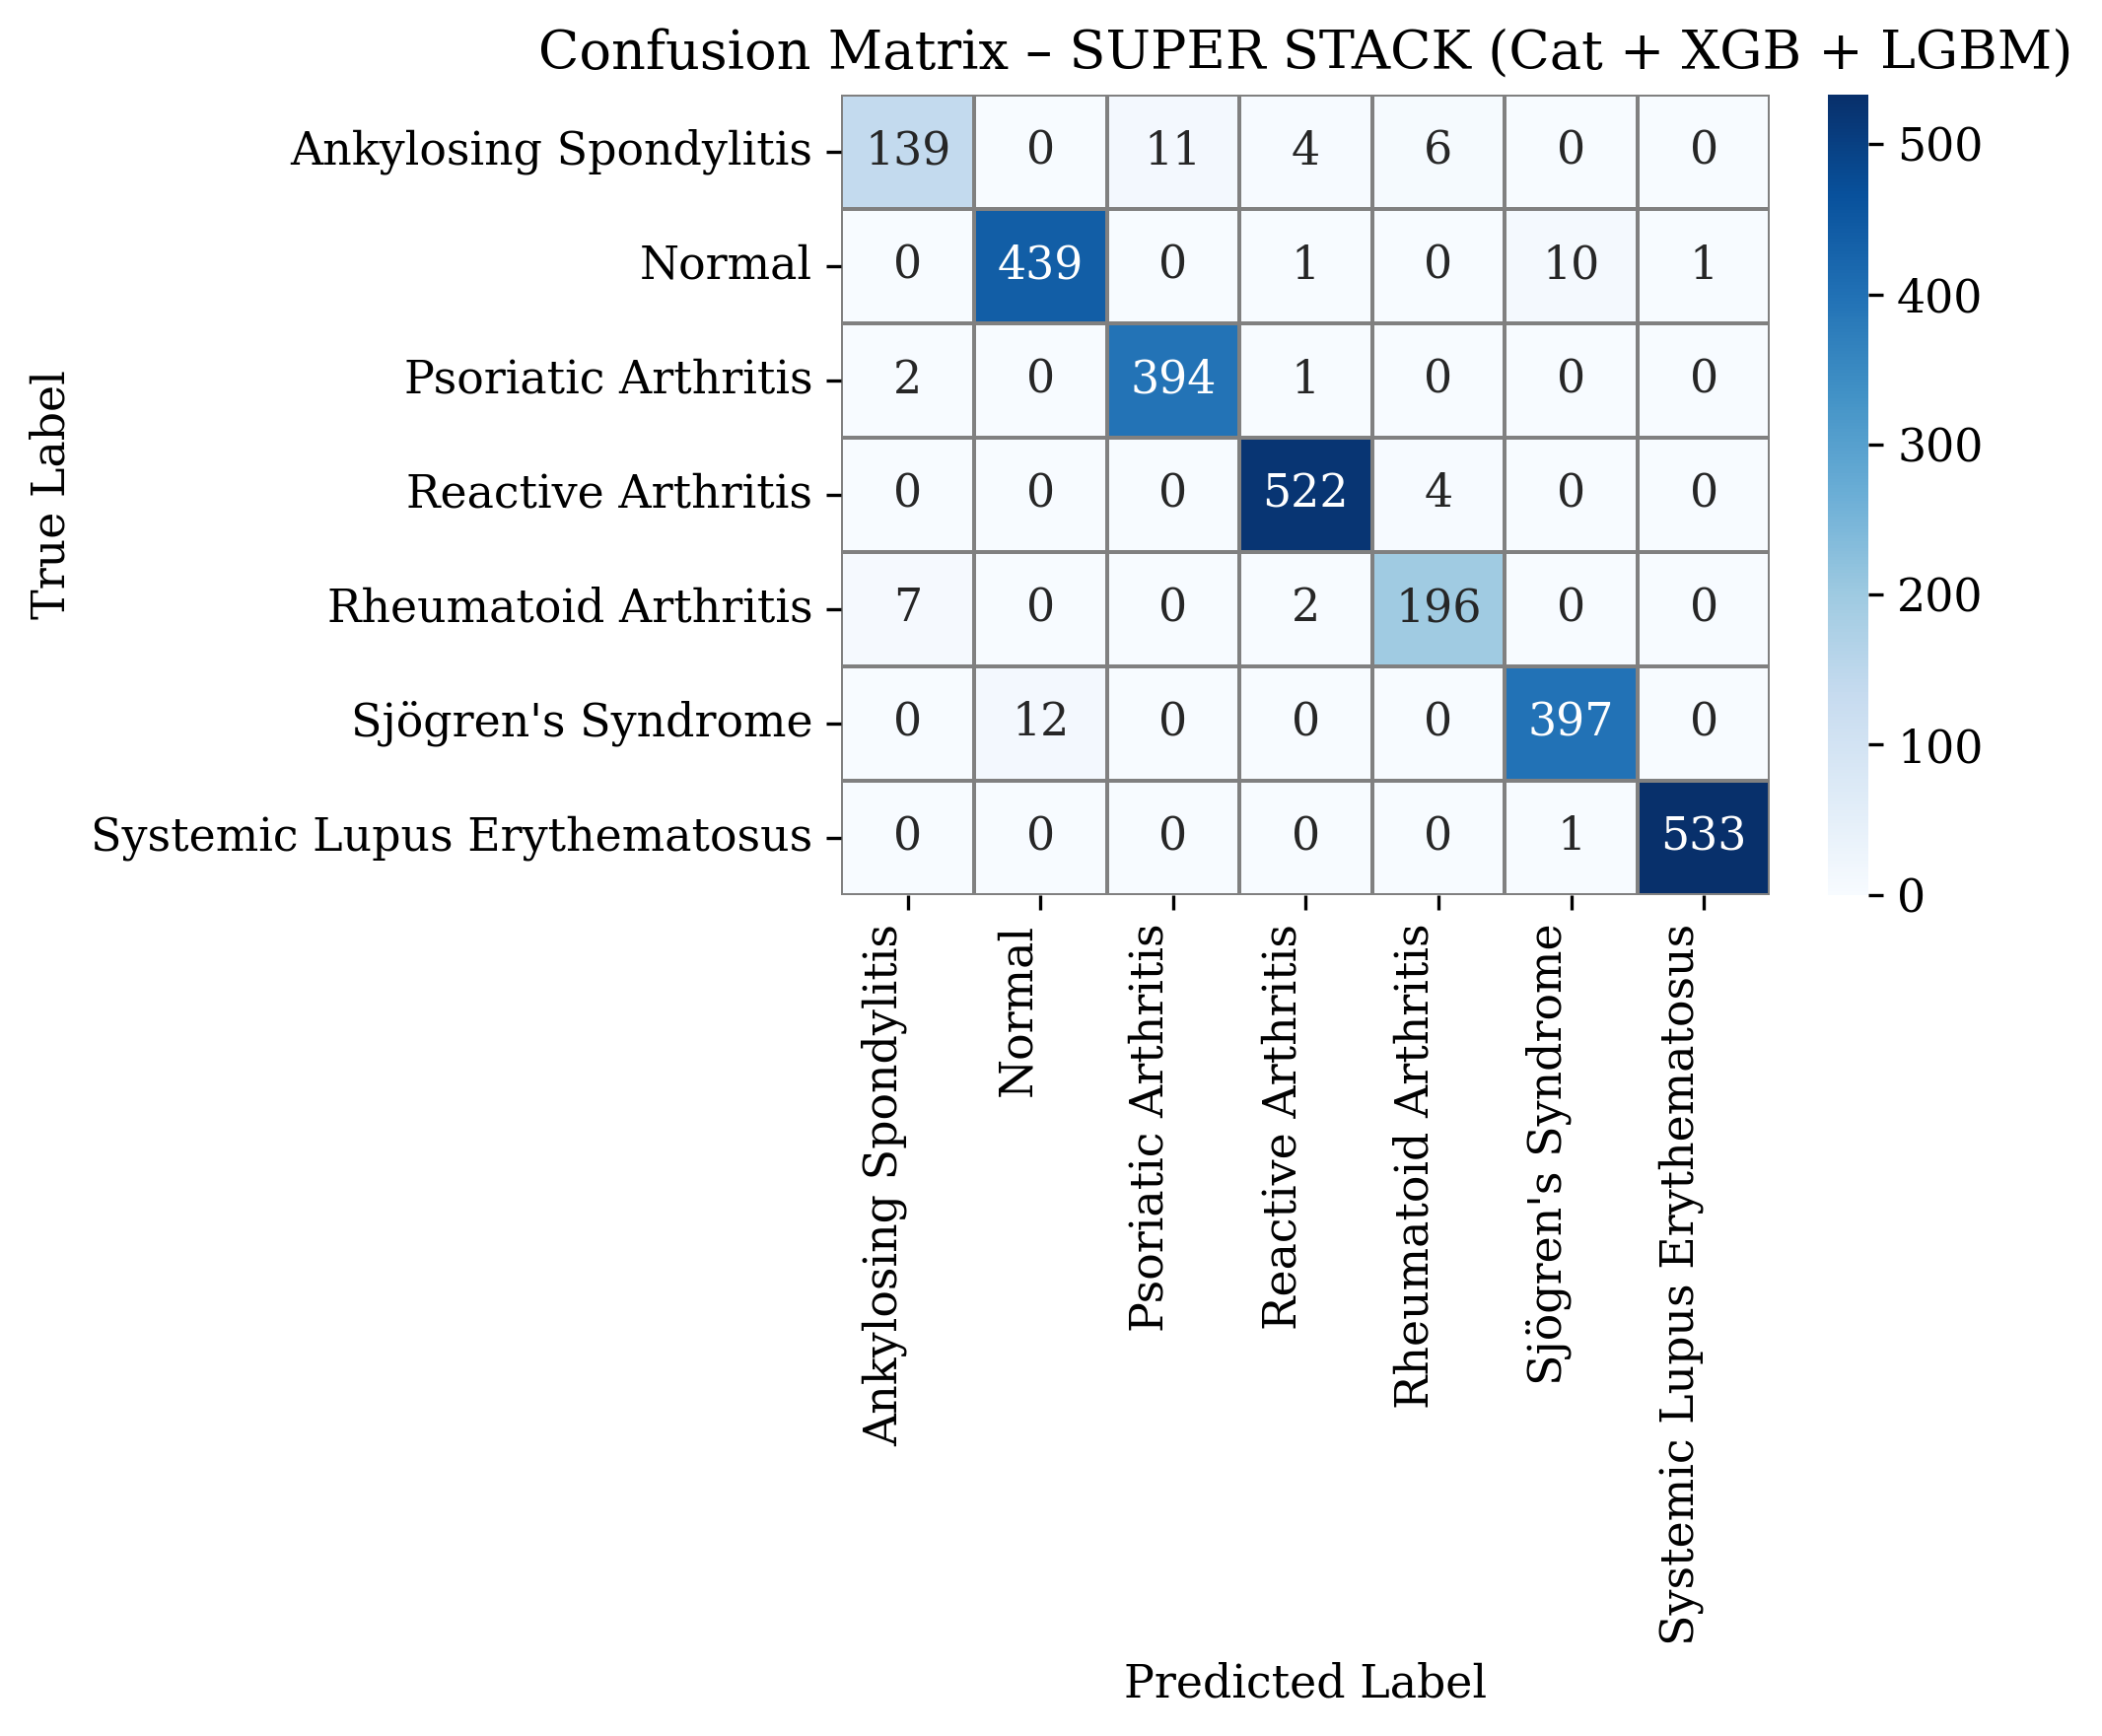

In [5]:
# ======================================================
# 13. CONFUSION MATRIX (SUPER STACK)
# ======================================================

from sklearn.metrics import confusion_matrix


y_pred = best_model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)


class_labels = le_y.inverse_transform(np.unique(y_test))


plt.figure(figsize=(7, 6), dpi=300)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,
    linecolor="gray"
)

plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)
plt.title(f"Confusion Matrix – {best_model_name}", fontsize=13)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()


plt.savefig(
    "Q1_Confusion_Matrix.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


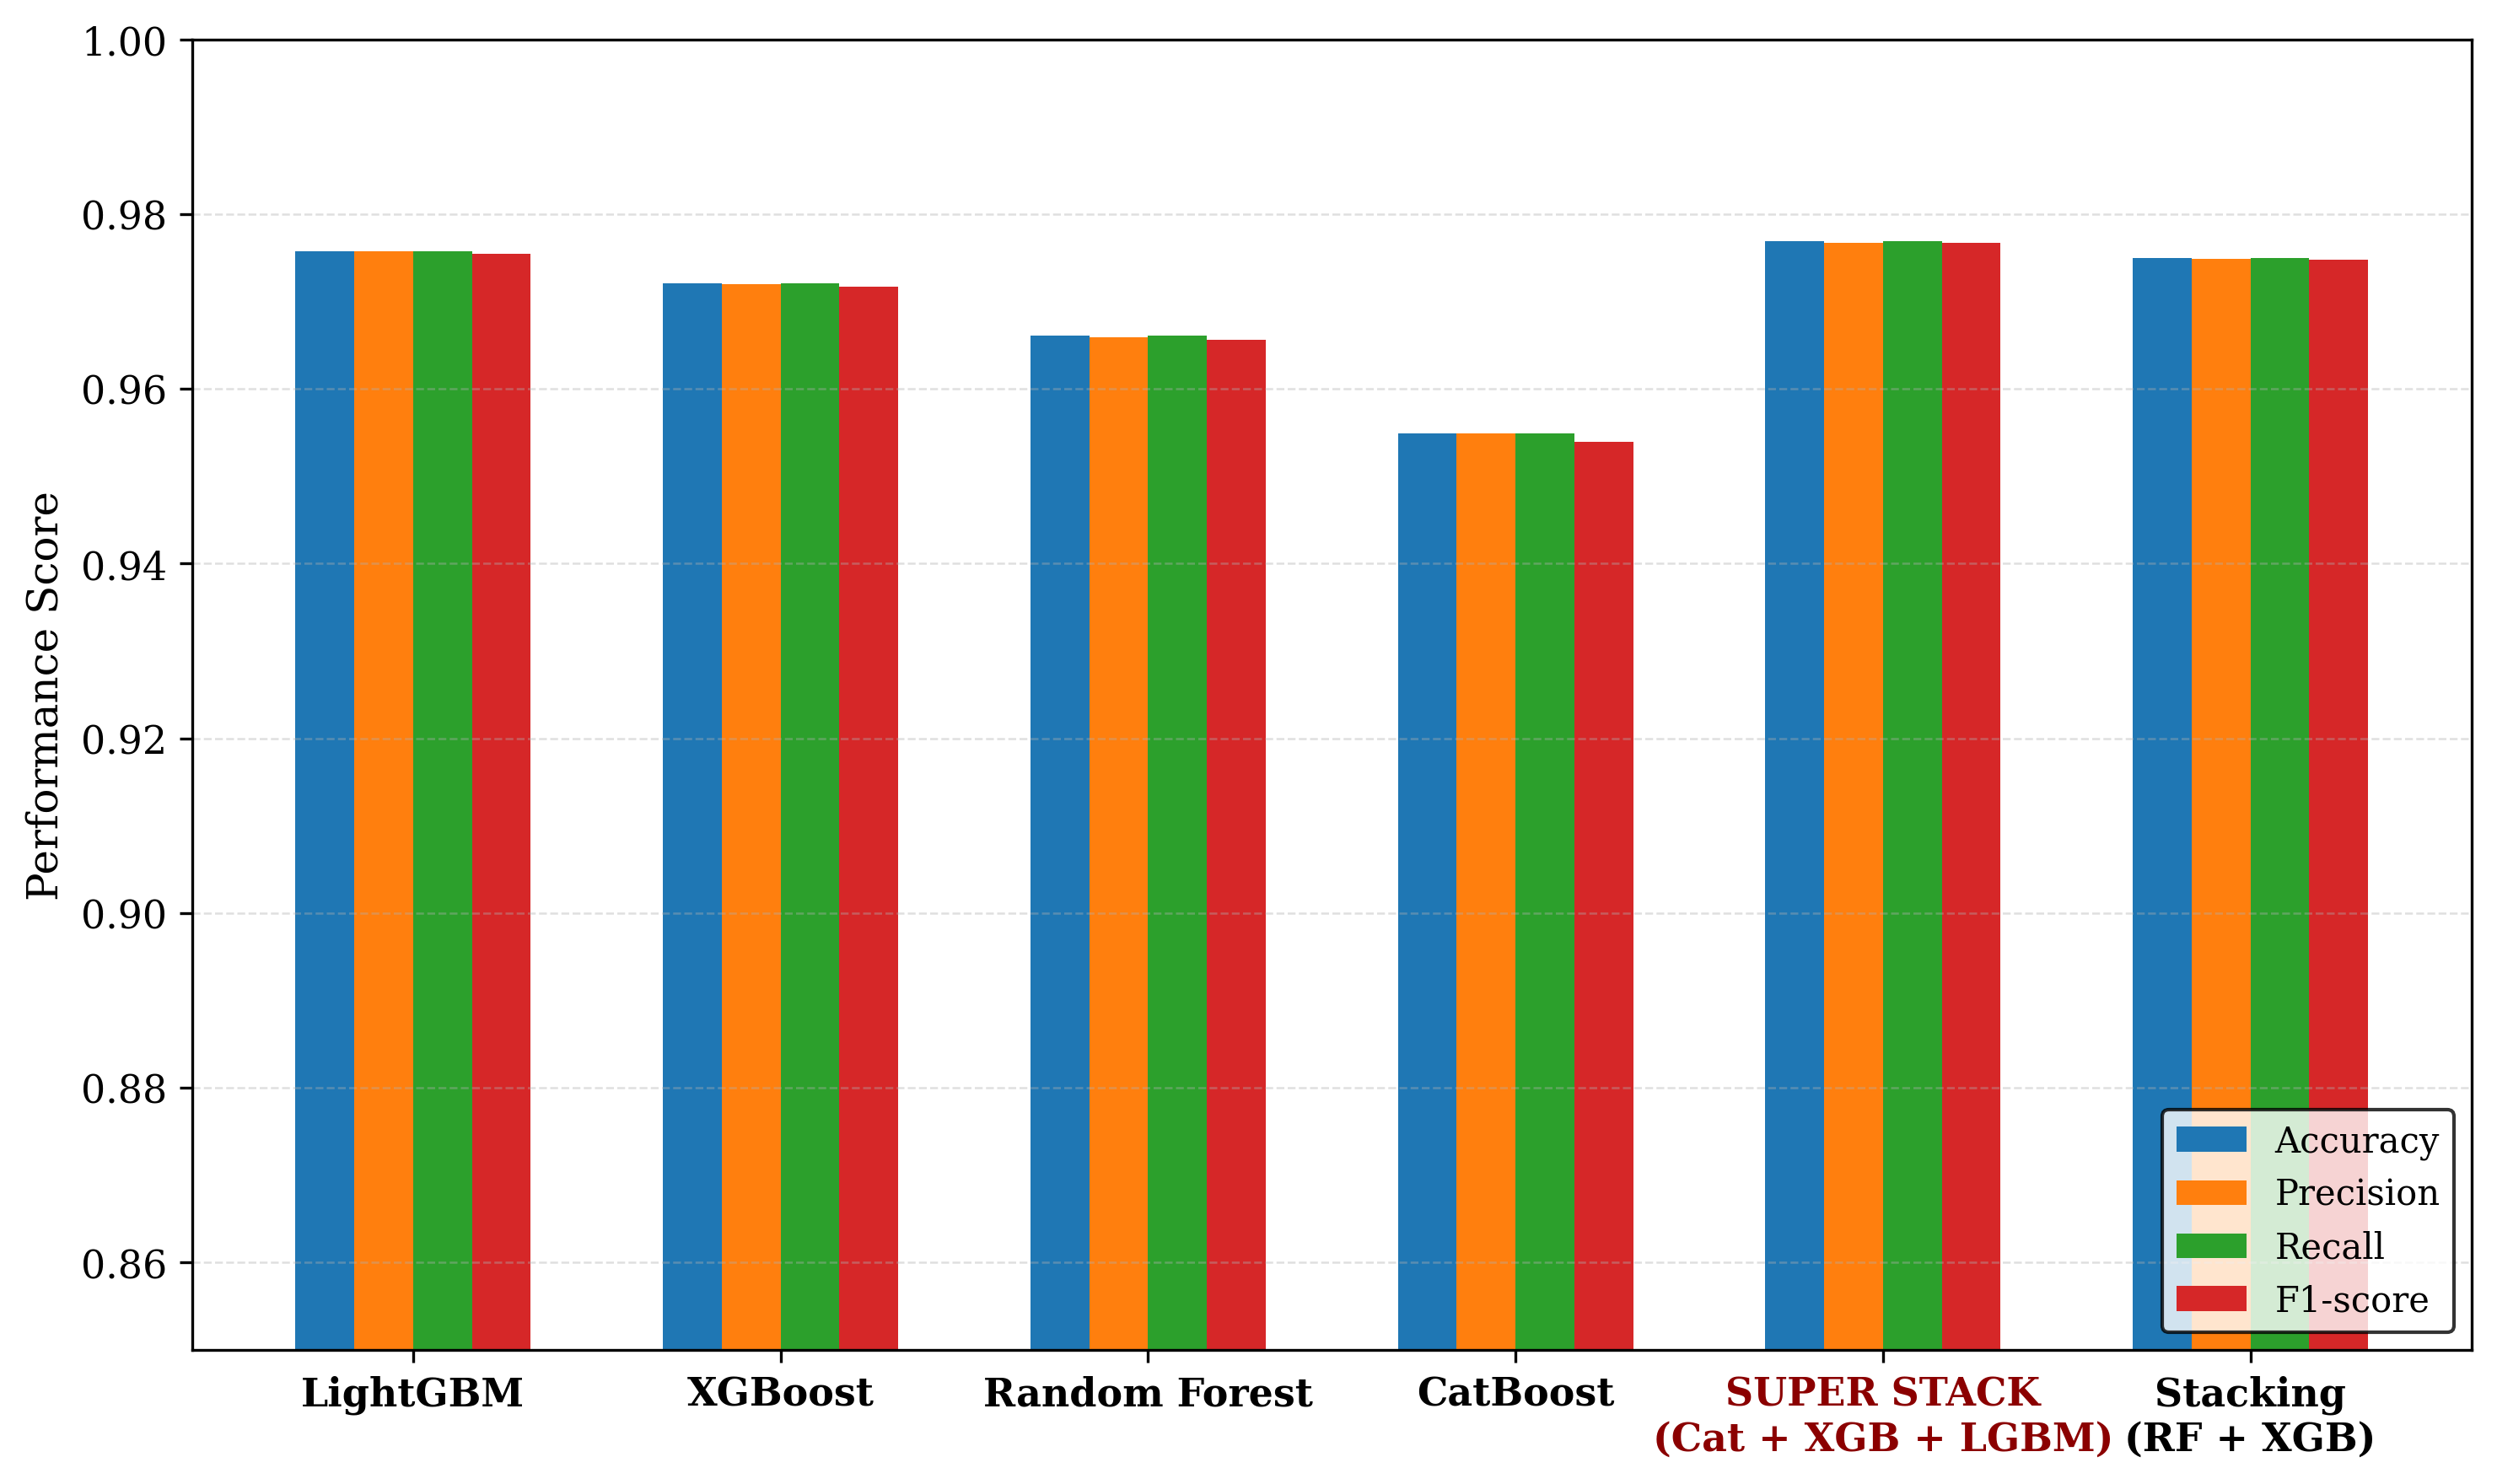

In [6]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


all_results_df = pd.concat([results_df, stack_df], ignore_index=True)


custom_model_names = [
    "LightGBM",
    "XGBoost",
    "Random Forest",
    "CatBoost",
    "SUPER STACK\n(Cat + XGB + LGBM)",
    "Stacking\n(RF + XGB)"
]

all_results_df["Display_Model"] = custom_model_names


plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11
})

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = np.arange(len(all_results_df))
width = 0.16

plt.figure(figsize=(10, 6), dpi=300)

# --------------------------------------------------
# Bars
# --------------------------------------------------
plt.bar(x - 1.5*width, all_results_df["Accuracy"], width=width, label="Accuracy")
plt.bar(x - 0.5*width, all_results_df["Precision"], width=width, label="Precision")
plt.bar(x + 0.5*width, all_results_df["Recall"], width=width, label="Recall")
plt.bar(x + 1.5*width, all_results_df["F1 Score"], width=width, label="F1-score")


plt.xticks(
    x,
    all_results_df["Display_Model"],
    rotation=0,
    ha="center",
    fontweight="bold"
)

plt.ylabel("Performance Score", fontsize=12)
plt.ylim(0.85, 1.0)


plt.legend(
    loc="lower right",
    frameon=True,
    fontsize=10,
    edgecolor="black"
)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.4)


for label in plt.gca().get_xticklabels():
    if "SUPER STACK" in label.get_text():
        label.set_color("darkred")
        label.set_fontweight("bold")



# --------------------------------------------------
# SAVE IMAGE
# --------------------------------------------------
plt.tight_layout()
plt.savefig(
    "Q1_Model_Performance_Comparison.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()